In [1]:
# import necessary modules
from sklearn.feature_selection import f_regression, mutual_info_regression
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import sys
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

# settings to display all columns
pd.set_option("display.max_columns", None)

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


VERSION = 16
VAL_SIZE = 0.20   # 20%

Python       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.1


In [2]:
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
data = pd.read_csv('data_train_0509.csv')
data.head()

,bodyType,brand,color,fuelType,numberOfDoors,productionDate,vehicleTransmission,enginePower,mileage,drivetrain,driveSide,ownersCount,tcp,rarity,price,model,vendor,train,sell_id,transmission,price_log,RUB_USD_rate,price_usd,km_per_year,carNovelty,prodDate_3Y,prodDate_5Y,ownershipTimeIsNull,descriptionIsNull,newCar,brandPopular,modelPopular,colorPopular,description_words_count
0,10,0,15,0,3,1991,2,5.164786,12.765691,2,0,3,1,6,200000.0,2,2,1,0,1,12.206073,75.2048,2659.404719,12068.965517,1,1,1,1,0,0,1,1,1,3.496508
1,10,0,7,0,3,1986,2,4.510860,12.063501,1,0,3,1,6,60000.0,2,2,1,0,1,11.002100,75.2048,797.821416,5100.705882,4,1,1,1,0,0,1,1,0,3.091042
2,12,0,13,0,4,1989,2,4.919981,12.345839,2,0,3,1,6,99000.0,2,2,1,0,1,11.502875,75.2048,1316.405336,7419.354839,1,1,1,1,0,0,1,1,1,5.111988
3,10,0,11,0,3,1989,2,4.510860,12.388398,1,0,3,1,6,65000.0,2,2,1,0,1,11.082143,75.2048,864.306534,7741.935484,1,1,1,1,1,0,1,1,1,0.693147
4,10,0,15,0,3,1991,2,4.624973,12.611541,1,0,3,0,6,100000.0,2,2,1,0,1,11.512925,75.2048,1329.702359,10344.827586,1,1,1,1,0,0,1,1,1,3.555348


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121502 entries, 0 to 121501
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   bodyType                 121502 non-null  int64  
 1   brand                    121502 non-null  int64  
 2   color                    121502 non-null  int64  
 3   fuelType                 121502 non-null  int64  
 4   numberOfDoors            121502 non-null  int64  
 5   productionDate           121502 non-null  int64  
 6   vehicleTransmission      121502 non-null  int64  
 7   enginePower              121502 non-null  float64
 8   mileage                  121502 non-null  float64
 9   drivetrain               121502 non-null  int64  
 10  driveSide                121502 non-null  int64  
 11  ownersCount              121502 non-null  int64  
 12  tcp                      121502 non-null  int64  
 13  rarity                   121502 non-null  int64  
 14  pric

####   Выделим тестовую и тренировочную части

In [5]:
X = data.query('train == 1').drop(['train', 'price', 'price_log', 'price_usd', 'RUB_USD_rate'], axis=1)
X_sub = data.query('train == 0').drop(['train', 'price', 'price_log', 'price_usd', 'RUB_USD_rate'], axis=1)

y = data[data.train == 1]['price']

X.shape, X_sub.shape, y.shape

((86816, 29), (34686, 29), (86816,))

#### Train Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69452, 29), (17364, 29), (69452,), (17364,))

In [ ]:
# scaler = MinMaxScaler()
# X_train1 = scaler.fit_transform(X_train)
# X_test1 = scaler.transform(X_test)

# 5. Model 1. Создадим "наивную" модель 

In [7]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

# Находим median по экземплярам mileage в трейне и размечаем тест
predict = X_test['mileage'].map(
    tmp_train.groupby('mileage')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")
# Точность наивной модели по метрике MAPE: 72.97%

Точность наивной модели по метрике MAPE: 72.97%


# 6. Model 2 : CatBoost

In [8]:
# для target 'price'
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         )

model.save_model('catboost_single_model_baseline.model')

# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
# Точность модели по метрике MAPE: 15.42%

Точность модели по метрике MAPE: 15.42%


### Log Traget

In [9]:
# для target 'price'
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, np.log(y_train),
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True,
          )

model.save_model('catboost_single_model_2_baseline.model')

predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")
# Точность модели по метрике MAPE: 12.63%

# с удалением признаков на каггле не отправляла
# Точность модели по метрике MAPE: 12.66%
# данные от 05.09.2021
# Точность модели по метрике MAPE: 12.62%
# на kaggle скор 13.02113 (место)

Точность модели по метрике MAPE: 12.62%


# 7. Model 3. Lazypredict

Воспользуемся библиотекой `Lazypredict` для нахождения моделей, которые на дефолтных параметрах отрабатывают лучше с нашими данными. Так как модели с логарифмом таргета показывают лучшие оценки MAPE, то в дальнейшем при построении моделей будем использовать логарифм таргета.

In [ ]:
# !pip install lazypredict

In [40]:
# import lazypredict
# from lazypredict.Supervised import LazyRegressor
# from sklearn.utils import shuffle

In [41]:
# mae = mean_absolute_error
# regr=LazyRegressor(verbose=0,predictions=True, custom_metric=mae)
# # fit and train the model 
# start_time_2=time.time()
# models, predictions=regr.fit(X_train, X_test, np.log(y_train), np.log(y_test))
# end_time_2=time.time()

100%|███████████████████████████████████████| 42/42 [1:26:27<00:00, 123.51s/it]


In [42]:
# models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_error
Model,,,,,
RandomForestRegressor,0.96,0.96,0.20,67.85,0.13
ExtraTreesRegressor,0.96,0.96,0.20,61.01,0.13
XGBRegressor,0.96,0.96,0.20,13.26,0.14
BaggingRegressor,0.96,0.96,0.21,7.43,0.13
HistGradientBoostingRegressor,0.96,0.96,0.21,3.86,0.15
LGBMRegressor,0.96,0.96,0.22,1.88,0.15
NuSVR,0.95,0.95,0.22,2728.43,0.15
SVR,0.95,0.95,0.22,2012.51,0.15
MLPRegressor,0.95,0.95,0.24,66.70,0.17


**Вывод:** Используя **LazyRegressor** получили лучших 5 моделей для нашего набора данных:
- RandomForestRegressor
- XGBRegressor	
- ExtraTreesRegressor
- BaggingRegressor	
- HistGradientBoostingRegressor

В отдельности попробуем каждую из моделей, чтобы найти лучшую

## # Модель 1: RandomForestRegressor

In [9]:
# Построим модель на дефолтных параметрах

# # без логарифмирования целевой переменной
# rf = RandomForestRegressor(random_state = RANDOM_SEED)
# rf.fit(X_train, y_train)
# rf_pred = rf.predict(X_test)

# print(
#     f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, rf_pred))*100:0.2f}%")

# # с логарифмированием целевой переменной
# rf_log = RandomForestRegressor(random_state = RANDOM_SEED)
# rf_log.fit(X_train, np.log(y_train))
# rf_log_pred = np.exp(rf_log.predict(X_test))

# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, rf_log_pred))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 12.89%
# Точность модели на kaggle MAPE 12,12418% 

Точность модели по метрике MAPE с логтаргетом: 12.89%


In [11]:
# # Попробуем подобрать гиперпараметры для нашей модели

# random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=4)],
#                'max_features': ['auto', 'sqrt', 'log2'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}

# rfr = RandomForestRegressor(random_state=RANDOM_SEED)
# rf_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
#                                n_iter=100, cv=3, verbose=10, random_state=RANDOM_SEED, n_jobs=-1)

# rf_random.fit(X_train, np.log(y_train))
# rf_random.best_params_

# # Лучшими оказались следующие параметры:
#  best_params_
#  {'bootstrap': True,
#   'max_depth': None,
#   'max_features': 'auto',
#   'min_samples_leaf': 1,
#   'min_samples_split': 2,
#   'n_estimators': 300}
#  rf_random.best_estimator_ = RandomForestRegressor(n_estimators=300, random_state=42)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 55

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [9]:
# # Обучим модель на лучших гиперпараметрах

# #best_rfr = rf_random.best_estimator_
# best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
#                       , n_estimators=300
#                       , min_samples_split=2
#                       , min_samples_leaf=1
#                       , max_features='auto'
#                       , max_depth=None
#                       , bootstrap=True)

# # best_rfr.fit(X_train, y_train)
# best_rfr.fit(X_train, np.log(y_train))

# # predict_rfr = best_rfr.predict(X_test)
# predict_rfr = np.exp(best_rfr.predict(X_test))
# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_rfr))*100:0.2f}%")

# # Точность модели по метрике MAPE с логтаргетом: 12.84%
# # Точность модели на kaggle MAPE 12.05232%

Точность модели по метрике MAPE с логтаргетом: 12.84%


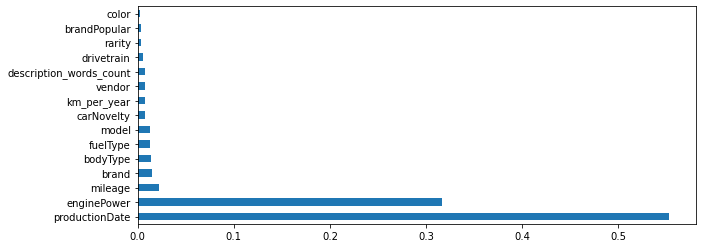

In [10]:
# # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
# plt.rcParams['figure.figsize'] = (10,4)
# feat_importances = pd.Series(best_rfr.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh');

## # Модель 2: XGBRegressor

In [ ]:
# !pip install xgboost

In [9]:
# import xgboost as xgb

In [19]:
# # можно попробовать менять learning_rate (0.05, 0.03, 0.01), max_depth (3,5,8,12,24,36)

# # без логарифмирования целевой переменной
# xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
#                           learning_rate=0.05, max_depth=12, alpha=1,
#                           n_estimators=1000)
# xgb_reg.fit(X_train, y_train)
# print(
#     f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, xgb_reg.predict(X_test)))*100:0.2f}%")

# с логарифмированием целевой переменной
# xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
#                           learning_rate=0.05, max_depth=12, alpha=1,
#                           n_estimators=1000)
# xgb_reg.fit(X_train, np.log(y_train))
# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, np.exp(xgb_reg.predict(X_test))))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 12.96%
# # Точность модели на kaggle MAPE 12.33125%

Попробуем с логарифмом таргета разную глубину

In [20]:
# Попробуем с логарифмом таргета разную глубину

# def xgb_reg_learn(depth):
#     xgb_list = []
#     for i in depth:
#         xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
#                                         learning_rate=0.05, max_depth=i, alpha=1,
#                                         n_estimators=1000)
#         xgb_reg.fit(X_train, np.log(y_train))
#         xgb_list.append(xgb_reg)
#         print(
#             f"Точность модели по метрике MAPE с логтаргетом и max_depth={i}: {(mape(y_test, np.exp(xgb_reg.predict(X_test))))*100:0.2f}%")
#     return xgb_list

# depth = [3,5,8,12,24,36]
# xgb_list = xgb_reg_learn(depth)

# Точность модели по метрике MAPE с логтаргетом и max_depth=3: 15.41%
# Точность модели по метрике MAPE с логтаргетом и max_depth=5: 13.31%
# Точность модели по метрике MAPE с логтаргетом и max_depth=8: 12.28%
# Точность модели по метрике MAPE с логтаргетом и max_depth=12: 12.22%
# Точность модели по метрике MAPE с логтаргетом и max_depth=24: 12.31%
# Точность модели по метрике MAPE с логтаргетом и max_depth=36: 12.31%
# Точность модели на kaggle MAPE 11.3500%

In [21]:
# Параметры лучшей модели
# best_xgb = xgb_list[3]
# best_xgb

# XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
#              importance_type='gain', interaction_constraints='',
#              learning_rate=0.05, max_delta_step=0, max_depth=12,
#              min_child_weight=1, missing=nan, monotone_constraints='()',
#              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
#              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
#              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
# feature_important = best_xgb.get_booster().get_score(importance_type='weight')
# keys = list(feature_important.keys())
# values = list(feature_important.values())

# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
# data.plot(kind='barh');

## # Модель 3: ExtraTreesRegressor

In [23]:
# Построим модель на дефолтных параметрах

# # без логарифмирования целевой переменной
# etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
# etr.fit(X_train, y_train)
# etr_pred = etr.predict(X_test)

# print(
#     f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, etr_pred))*100:0.2f}%")

# # с логарифмированием целевой переменной
# etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
# etr.fit(X_train, np.log(y_train))
# etr_pred = np.exp(etr.predict(X_test))

# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, etr_pred))*100:0.2f}%")

# # Точность модели по метрике MAPE с логтаргетом: 13.10%
## Точность модели на kaggle MAPE 10.95491%

In [64]:
# # Попробуем подобрать гиперпараметры для нашей модели

# random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
#                'max_features': ['auto', 'sqrt','log2'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}

# etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
# etr_random = RandomizedSearchCV(estimator = etr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
# # rf_random.fit(X_train, y_train)
# etr_random.fit(X_train, np.log(y_train))
# etr_random.best_params_

# Лучшие параметры для нашей модели
#  best_params_
# {'n_estimators': 300,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'auto',
#  'max_depth': None,
#  'bootstrap': True}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 38.2min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 41.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 44.2min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 46

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [24]:
# # Обучим модель на лучших гиперпараметрах

# best_etr = ExtraTreesRegressor(random_state=RANDOM_SEED, 
#                                n_estimators=300,
#                                min_samples_split=2,
#                                min_samples_leaf=1,
#                                max_features='auto',
#                                max_depth=None,
# best_etr.fit(X_train, np.log(y_train))

# predict_etr = np.exp(best_etr.predict(X_test))
# predict_submission = np.exp(best_etr.predict(X_sub))

# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_etr))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 12.89%
# Точность модели на kaggle MAPE 12.09228%

In [25]:
# plt.rcParams['figure.figsize'] = (10,4)
# feat_importances = pd.Series(best_etr.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh');

## # Модель 4: BaggingRegressor

## 4.1. Со случайным лесом

In [27]:
# best_rfr
# RandomForestRegressor(n_estimators=300, random_state=42)

In [18]:
# Обучим на дефолтных параметрах

# bagg_rfr_d = BaggingRegressor(best_rfr, n_jobs=1, random_state=RANDOM_SEED)
# bagg_rfr_d.fit(X_train, np.log(y_train))
# predict_bagg_rfr_d = np.exp(bagg_rfr_d.predict(X_test))
# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_rfr_d))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 13.00%
# Точность модели на kaggle MAPE 13.12%    

Точность модели по метрике MAPE с логтаргетом: 13.00%


In [15]:
# Добавим к параметрам n_estimators=3

# bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
# bagg_rfr.fit(X_train, np.log(y_train))
# predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_rfr))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 13.19%
# Точность модели на kaggle MAPE 13.31105%

Точность модели по метрике MAPE с логтаргетом: 13.19%


## 4.2. С XGBRegressor

In [ ]:
# best_xgb

# XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
#              importance_type='gain', interaction_constraints='',
#              learning_rate=0.05, max_delta_step=0, max_depth=12,
#              min_child_weight=1, missing=nan, monotone_constraints='()',
#              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
#              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
#              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
# Обучим на дефолтных параметрах

# bagg_xgb = BaggingRegressor(best_xgb, n_jobs=1, random_state=RANDOM_SEED)
# bagg_xgb.fit(X_train, np.log(y_train))
# predict_bagg_xgb = np.exp(bagg_xgb.predict(X_test))
# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_xgb))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 12.18%
# Точность модели на kaggle MAPE 13.31105%

In [29]:
# Добавим к параметрам n_estimators=3

# bagg_xgb = BaggingRegressor(best_xgb, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
# bagg_xgb.fit(X_train, y_train)
# predict_bagg_xgb = np.exp(bagg_xgb.predict(X_test))
# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_xgb))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 12.29%
# Точность модели на kaggle MAPE 12.07452%   

## 4.3. С ExtraTreesRegressor

In [30]:
# etr 
# ExtraTreesRegressor(random_state=42)

In [31]:
# Обучим на дефолтных параметрах

# bagg_etr = BaggingRegressor(etr, n_jobs=1, random_state=RANDOM_SEED)
# bagg_etr.fit(X_train, np.log(y_train))
# predict_bagg_etr = np.exp(bagg_etr.predict(X_test))
# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_etr))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 12.92%
# Точность модели на kaggle MAPE 11.91719%

In [32]:
# Добавим к параметрам n_estimators=3

# bagg_etr = BaggingRegressor(etr, n_jobs=1, n_estimators = 3, random_state=RANDOM_SEED)
# bagg_etr.fit(X_train, np.log(y_train))
# predict_bagg_etr = np.exp(bagg_etr.predict(X_test))
# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_etr))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 13.12%
# Точность модели на kaggle MAPE 12.41893%

## # Модель 5: HistGradientBoostingRegressor

In [90]:
# Запускаем дефолтную модель на логорифме цены

# hgbr = HistGradientBoostingRegressor(random_state=RANDOM_SEED)

# hgbr.fit(X_train, np.log(y_train))

# hgbr_pred = np.exp(hgbr.predict(X_test))
# predict_submission = np.exp(hgbr.predict(X_sub))

# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, hgbr_pred))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 15.28%
# Точность модели на kaggle MAPE: 16.10811%

In [33]:
# Запускаем RandomizedSearchCV для HistGradientBoostingRegressor.

# random_grid = {'max_iter': [1000, 1200, 1500],
#                'learning_rate': [0.1],
#                'max_depth': [25, 50, 75],
#                'l2_regularization': [1.5]}

# hgbr = HistGradientBoostingRegressor(random_state=RANDOM_SEED)
# hgbr_random = RandomizedSearchCV(estimator=hgbr,
#                                  param_distributions=random_grid,
#                                  n_iter=100, cv=3,
#                                  verbose=10,
#                                  random_state=RANDOM_SEED,
#                                  n_jobs=-1)

# hgbr_random.fit(X_train, np.log(y_train))

# Лучшие параметры:
#hgbr_random.best_params_
# {'max_iter': 1000,
# 'max_depth': 25,
# 'learning_rate': 0.1,
# 'l2_regularization': 1.5}

In [34]:
# Запускаем HistGradientBoostingRegressor на найденных параметрах

# hgbr = HistGradientBoostingRegressor(random_state=RANDOM_SEED, max_iter =1000,
#                                      max_depth=25,
#                                      learning_rate=0.1,
#                                      l2_regularization=1.5)

# hgbr.fit(X_train, np.log(y_train))

# hgbr_pred = np.exp(hgbr.predict(X_test))
# predict_submission = np.exp(hgbr.predict(X_sub))

# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, hgbr_pred))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 13.16%
# Точность модели на kaggle MAPE: 13.61184%

# 8. Model 4. StackingRegressor

**Нужно выбрать 2 или 3 лучших модели для стекинга, определить какую модель лучше взять последней (решающей)** 

Брать много сложных моделей не будем, так как даже при 2-3 моделях выполнение обучения идет достаточно долго.
Выбирем для стекинга самые лучшие модели,  которые мы получили: Xgboosting, ExtraTreesRegressor. Для обработки результатов в качестве последней попробуем взять линейную регрессию и CatBoosting.

# 8.1 Xgboosting, ExtraTreesRegressor+LinearRegression

In [36]:
# estimators = [('etr',ExtraTreesRegressor()),
#               ('xgb_reg',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, \
#                       max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000))]

# st_ensemble = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

# # оцениваем точность
# st_ensemble.fit(X_train, np.log(y_train))
# predict_e = np.exp(st_ensemble.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

# Точность модели по метрике MAPE: 12.10%
# Точность модели на kaggle MAPE 10.98%

# 8.2 Xgboosting, ExtraTreesRegressor+CatBoostRegressor

In [37]:
# estimators = [('etr',ExtraTreesRegressor()),
#               ('xgb_reg',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, \
#                       max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000))]

# st_ensemble = StackingRegressor(estimators=estimators,final_estimator=CatBoostRegressor())

# # оцениваем точность
# st_ensemble.fit(X_train, np.log(y_train))
# predict_e = np.exp(st_ensemble.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

# Точность модели по метрике MAPE: 12.28%
# Точность модели на kaggle MAPE 11.14844%

**Кроме этих 2-х моделей стекинга, мы попробовали сделали стекинг с не самыми лучшими моделями и LinearRegression**

# 8.3 RandomForestRegressor, ExtraTreesRegressor+LinearRegression

In [39]:
# estimators = [('rfr', RandomForestRegressor(random_state=RANDOM_SEED
#                       , n_estimators=300
#                       , min_samples_split=2
#                       , min_samples_leaf=1
#                       , max_features='auto'
#                       , max_depth=None
#                       , bootstrap=True)),
#               ('etr', ExtraTreesRegressor(random_state = RANDOM_SEED))]

# st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# # оцениваем точность
# st_ensemble_1.fit(X_train, np.log(y_train))
# predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")

# Точность модели по метрике MAPE: 12.64%
# Точность модели на kaggle MAPE 11.19165%

# 8.4 BaggingRegressor(xgb.XGBRegressor), ExtraTreesRegressor+LinearRegression

In [40]:
# estimators = [('bagr', BaggingRegressor(xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
#                           learning_rate=0.05, max_depth=12, alpha=1,
#                           n_estimators=1000), n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)),
#               ('etr', ExtraTreesRegressor(random_state = RANDOM_SEED))]

# st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# # оцениваем точность
# st_ensemble_1.fit(X_train, np.log(y_train))
# predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")

# Точность модели по метрике MAPE: 12.16%
# Точность модели на kaggle MAPE 11.44763%

# 8.5 BaggingRegressor(ExtraTreesRegressor), ExtraTreesRegressor+LinearRegression

In [1]:
# estimators = [('bagr', BaggingRegressor(ExtraTreesRegressor(random_state = RANDOM_SEED), n_jobs=1, random_state=RANDOM_SEED)),
#               ('etr', ExtraTreesRegressor(random_state = RANDOM_SEED))]

# st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# # оцениваем точность
# st_ensemble_1.fit(X_train, np.log(y_train))
# predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")
# Точность модели по метрике MAPE: 12.93%
# Точность модели на kaggle MAPE %

# Выбор модели

Во время исследования все модели запускались много раз. У нас были следующие параметры для проверки:
- логорифмировать или нет числовые признаки
- выбор обработки категориальных данных: OneHotEncoder, LabelEncoding
- проводить или нет стандартизацию данных перед обучением
- использовать логарифм таргета или нет
- использовать в качестве таргета приведение цены к ценам 2020 в зависимости от курса доллара, т.е. в качества таргета использовать `price_usd`
- удалять или не удалять после анализа какие-то признаки для обучения модели

Результаты:
- стандартизация данных перед обучением не привела к существенному улучшению метрики MAPE, поэтому от стандартизации отказались
- использование в качестве таргете `price_usd` не принесло сильного улучшение результата на kaggle, решено было от него отказаться
- удаление каких-либо признаков для модели только ухудшило метрику MAPE, отказались от удаления признаков из обучения

Модель:   
Наилучшую метрику MAPE на наших данных показывали модели на основе "деревьев" и бустинг.
Наиболее лучшие значения этой метрики были у следующих моделей:
- `ExtraTreesRegressor` с дефолтными параметрами и значением MAPE=10.95%
- `Xgboosting, ExtraTreesRegressor+LinearRegression` (модель стекинга с наилучшими моделями и последней линейнок регрессией) значение MAPE=10.98%
- `XGBRegressor` с параметрами max_depth=12 learning_rate=0.05 и значением MAPE=11.35%

В целом стекинг приводит к неплохим результатам, улучшая нашу метрику.  


**Однако лучшей моделью для наших данных стала модель `ExtraTreesRegressor` с дефолтными параметрами и значением MAPE=10.95%**

In [26]:
predict_submission = np.exp(etr.predict(X_sub))

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.711712e+05
1,1100549428,9.146044e+05
2,1100658222,8.840497e+05
3,1100937408,6.913856e+05
4,1101037972,6.953684e+05
5,1100912634,7.844940e+05
6,1101228730,6.149214e+05
7,1100165896,4.125470e+05
8,1100768262,1.601541e+06
9,1101218501,7.738608e+05


#  Выводы:
    
1. парсинг
2. EDA - в

3. Lazypred - 

**Таблица с результатами экспериментов:**

<table class="table">
  <thead>
    <tr>
      <th scope="col">Models/Metrics</th>
      <th scope="col">LazyPredic MAE</th>
      <th scope="col">Default Settings Train MAPE</th>
      <th scope="col">Default Settings Kaggle  MAPE</th>
      <th scope="col">Tuned Hyperparameter Train MAPE</th>
      <th scope="col">Tuned Hyperparameter Kaggle MAPE</th>
      <th scope="col">Comment</th>  
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>CatBoost</th>
      <td>-</td>
      <td>12.62%</td>
      <td>13.02%</td>
      <td>12.56%</td>
      <td>13.38%</td> 
      <td>Tuned: added cat_features_ids</td>  
    </tr>
    <tr>
      <th>RandomForestRegressor</th>
      <td>0.13</td>
      <td>12.89%</td>
      <td>12.12%</td>
      <td>12.84%</td>
      <td>12.05%</td> 
      <td>-</td>  
    </tr>
    <tr>
      <th>ExtraTreesRegressor</th>
      <td>0.13</td>
      <td>13.10%</td>
      <th>10.95%</th>
      <td>12.89%</td>
      <td>12.09%</td>
      <td>-</td>  
    </tr>
    <tr>
      <th>XGBRegressor</th>
      <td>0.14</td>
      <td>12.96%</td>
      <td>12.33%</td>
      <td>12.22%</td>
      <th>11.35%</th>
      <td>default model: learning_rate=0.05 best model: max_depth=12 learning_rate=0.05: 12.18%</td>   
    </tr>
    <tr>
      <th>BagginRegressor</th>
      <td>0.13</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>BagginRegressor с ExtraTreesRegressor</th>
      <td>-</td>
      <td>12.92%</td>
      <td>11.92%</td>
      <td>13.12%</td>
      <td>12.42%</td>
      <td>default: без n_estimators tunes: n_estimators = 3</td>  
    </tr>
    <tr>
      <th>BagginRegressor с RandomForestRegressor</th>
      <td>-</td>
      <td>13.00%</td>
      <td>13.12%</td>
      <td>13.19%</td>
      <td>13.31%</td>
      <td>default: без n_estimators tunes: n_estimators = 3</td>  
    </tr>
      <tr>
      <th>BagginRegressor с XGBRegressor</th>
      <td>-</td>
      <td>12.18%</td>
      <td>13.31%</td>
      <td>12.29%</td>
      <td>12.07%</td>
      <td>default: без n_estimators tunes: n_estimators = 3</td>    
    </tr>
  <tr>
      <th>HistGradientBoostingRegressor</th>
      <td>0.15</td>
      <td>15.28%</td>
      <td>16.11%</td>
      <td>13.16%</td>
      <td>13.61%</td>
      <td></td> 
    </tr>
    <tr>
      <th>StackingRegressor</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>  
    <tr>
      <th>Xgboosting, ExtraTreesRegressor+LinearRegression</th>
      <td></td>
      <td>12.10%</td>
      <th>10.98%</th>
      <td></td>
      <td></td>
      <td></td>  
    </tr>
    <tr>
      <th>Xgboosting, ExtraTreesRegressor+CatBoostRegressor</th>
      <td></td>
      <td>12.28%</td>
      <td>11.15%</td>
      <td></td>
      <td></td>
      <td></td>  
    </tr>  
    <tr>
      <th>RandomForestRegressor, ExtraTreesRegressor+LinearRegression</th>
      <td></td>
      <td>12.64%</td>
      <td>11.19%</td>
      <td></td>
      <td></td>
      <td></td>  
    </tr>  
    <tr>
      <th>BaggingRegressor(xgb.XGBRegressor), ExtraTreesRegressor+LinearRegression</th>
      <td></td>
      <td>12.16%</td>
      <td>11.45%</td>
      <td></td>
      <td></td>
      <td></td>  
    </tr>
    <tr>
      <th>BaggingRegressor(ExtraTreesRegressor), ExtraTreesRegressor+LinearRegression</th>
      <td></td>
      <td>12.93%</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>  
    </tr>  
  </tbody>
</table>